![Image of Yaktocat](https://i0.wp.com/ctbeertours.com/wp-content/uploads/2016/07/kickstarter-website-banner.jpg?fit=955%2C328)

Kickstarter jest to uruchomiona w 2009 roku platforma, poświęcona crowdfundingowi, czyli społecznościowym zbiórkom pieniędzy. Finansowane są tam projekty takie jak filmy, animacje, gry komputerowe, karciane, planszowe, komiksy, albumy muzyczne, a także projekty związane ze sztuką, modą, fotografią, publicystyką, teatrem, tańcem, jedzeniem oraz nowoczesnymi technologiami.Osoby, które chcą wesprzeć projekt wpłacają pieniądze. Jeśli w ustalonym czasie uda się zebrać zadeklarowaną przez pomysłodawców kwotę, pieniądze – po potrąceniu prowizji serwisu – są im wypłacane. Gdy wymagana kwota nie zostanie zebrana, pieniądze wracają do osób, które wsparły projekt.

In [22]:
import pandas as pd
import numpy as np
import string

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import BallTree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from IPython.display import Image
from IPython.core.display import HTML

Używamy zestawu danych ze strony https://www.kaggle.com/kemical/kickstarter-projects.

In [23]:
pd.set_option('display.max_columns', 12)
df = pd.read_csv('ks-projects-201801.csv')

In [24]:
print(df.shape)

(378661, 15)


In [25]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB
None


In [26]:
print(df.nunique())

ID                  378661
name                375764
category               159
main_category           15
currency                14
deadline              3164
goal                  8353
launched            378089
pledged              62130
state                    6
backers               3963
country                 23
usd pledged          95455
usd_pledged_real    106065
usd_goal_real        50339
dtype: int64


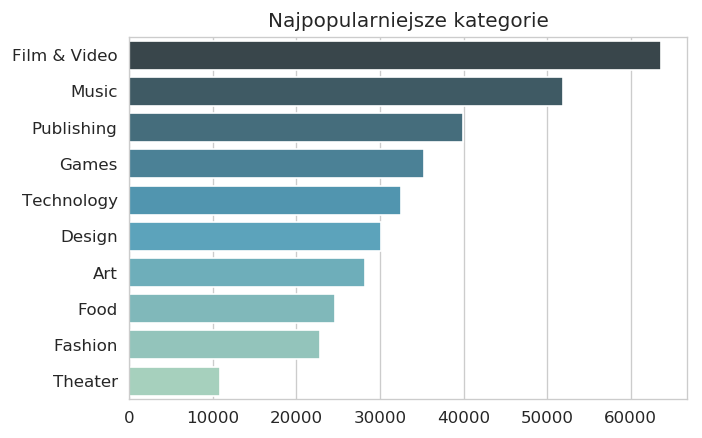

In [27]:
sns.set_style('whitegrid')
mains = df.main_category.value_counts().head(10)

x = mains.values
y = mains.index

fig = plt.figure(dpi=120)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="GnBu_d")

plt.title('Najpopularniejsze kategorie')
plt.show()

1. Pebble Time - 20.338.986 USD

![Image of Yaktocat](https://ksr-ugc.imgix.net/assets/012/032/069/46817a8c099133d5bf8b64aad282a696_original.png?ixlib=rb-1.1.0&crop=faces&w=1552&h=873&fit=crop&v=1463725702&auto=format&frame=1&q=92&s=43b2da867d3cc18964d8279d13e9f575)

2. Coolest Cooler - 13.285.226 USD
![Image of Yaktocat](https://ksr-ugc.imgix.net/assets/011/595/682/65a3f1f355d79198457b6d66526c0e88_original.jpg?ixlib=rb-1.1.0&crop=faces&w=1552&h=873&fit=crop&v=1463684988&auto=format&frame=1&q=92&s=5cb24bb172d07c304bc2e1e480708f9e)

3. Pebble 2, Time 2 - 12.779.843 USD
![Image of Yaktocat](https://ksr-ugc.imgix.net/assets/011/244/931/2430b84825e9c8e64d6b17faa20d2cb9_original.png?ixlib=rb-1.1.0&crop=faces&w=1552&h=873&fit=crop&v=1464876220&auto=format&frame=1&q=92&s=b0d0b243cdbb45eb61ef90cec2c77d35)

4. Kingdom Death: Monster 1.5 - 12.393.139 USD

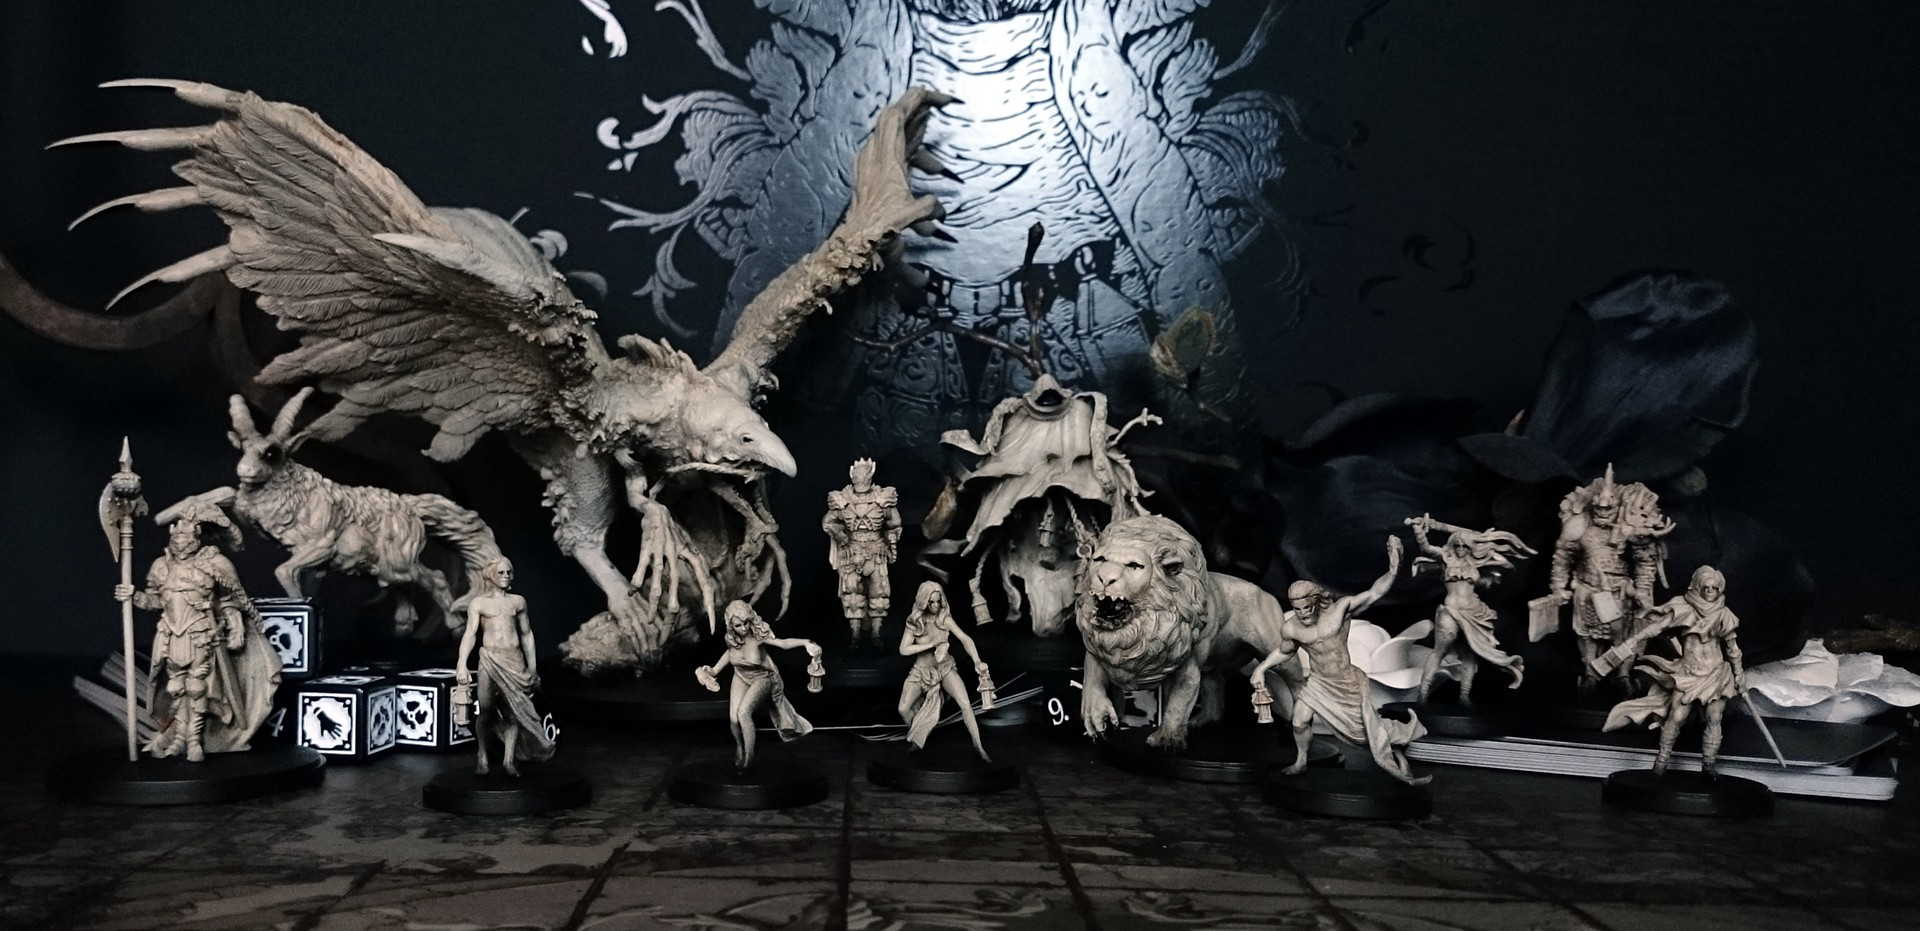

5. Pebble E-Paper Watch for iPhone and Android - 10.266.845 USD
![Image of Yaktocat](https://ksr-ugc.imgix.net/assets/011/334/500/5525884a63076aaa23356031e0b305c4_original.png?ixlib=rb-1.1.0&crop=faces&w=1552&h=873&fit=crop&v=1463681170&auto=format&frame=1&q=92&s=329794cf5724313dedb592a595239f98)

## Przygotowanie danych.

In [28]:
categorical_columns = ['main_category']
df = pd.get_dummies(df, columns=categorical_columns)
df = df[df["state"].isin(["failed", "successful"])]
df["state"] = df["state"].apply(lambda x: 1 if x=="successful" else 0)
df = df.drop(columns=['ID', 'name', 'pledged', 'goal', 'usd pledged', 'usd_pledged_real', 'category', 'currency', 'country'], axis=1)
df['launched'] = pd.to_datetime(df['launched'])
df['deadline'] = pd.to_datetime(df['deadline'])
df['duration_days'] = df['deadline'].subtract(df['launched'])
df['duration_days'] = df['duration_days'].astype('timedelta64[D]')
df = df.drop(columns=['launched', 'deadline'])

## Usuwanie wartości odstających.

In [29]:
q1 = df['usd_goal_real'].quantile(0.25)
q3 = df['usd_goal_real'].quantile(0.75)
iqr = q3 - q1
down = q1 - 1.5 * iqr
up = q3 + 1.5 * iqr
df['usd_goal_real'] = df['usd_goal_real'][(df['usd_goal_real'] > down) & (df['usd_goal_real'] < up)]
df = df.dropna(axis=0, how='any')

In [ ]:
X = df.drop(columns=['state'], axis=1)
y = df['state']

In [ ]:
sc = preprocessing.StandardScaler()
X = pd.DataFrame(sc.fit_transform(X.values), index=X.index, columns=X.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [ ]:
scorer = make_scorer(accuracy_score)
kfold = KFold(n_splits=5, random_state=11)

## Bayes

In [ ]:
clf_gnb = GaussianNB()
clf_gnb.fit(X_train,y_train)
clf_gnb.fit(X_train,y_train)
y_pred_gnb = clf_gnb.predict(X_test)
cv_gnb = cross_val_score(clf_gnb, X_train, y_train, cv=kfold, scoring=scorer)
print('Bayes avg:\t', cv_gnb.mean())

Bayes avg:	 0.739583828972046


## SVM

In [ ]:
clf_svm = LinearSVC(max_iter = 1000, C=1)
clf_svm.fit(X_train, y_train)
y_pred_svm= clf_svm.predict(X_test)
cv_svm = cross_val_score(clf_svm, X_train, y_train, cv=kfold, scoring=scorer)
print('svm results:\t', cv_svm)
print('svm result avg:\t', cv_svm.mean())